---
execute:
  cache: false
  eval: true
  echo: true
  warning: false
title: Hyperparameter Tuning with `spotpython` and `PyTorch` Lightning for the Diabetes Data Set Using a ResNet Model
jupyter: python3
---


In this section, we will show how `spotpython` can be integrated into the `PyTorch` Lightning
training workflow for a regression task.
It demonstrates how easy it is to use `spotpython` to tune hyperparameters for a `PyTorch` Lightning model.


In [1]:
#| label: 605_imports
#| echo: false
import os
from math import inf
import warnings
warnings.filterwarnings("ignore")

After importing the necessary libraries, the `fun_control` dictionary is set up via the `fun_control_init` function.
The `fun_control` dictionary contains

* `PREFIX`: a unique identifier for the experiment
* `fun_evals`: the number of function evaluations
* `max_time`: the maximum run time in minutes
* `data_set`: the data set. Here we use the `Diabetes` data set that is provided by `spotpython`.
* `core_model_name`: the class name of the neural network model. This neural network model is provided by `spotpython`.
* `hyperdict`: the hyperparameter dictionary. This dictionary is used to define the hyperparameters of the neural network model. It is also provided by `spotpython`.
* `_L_in`: the number of input features. Since the `Diabetes` data set has 10 features, `_L_in` is set to 10.
* `_L_out`: the number of output features. Since we want to predict a single value, `_L_out` is set to 1.

The `HyperLight` class is used to define the objective function `fun`.
It connects the `PyTorch` and the `spotpython` methods and is provided by `spotpython`.

In [2]:
#| label: 605_spotpython_setup

from spotpython.data.diabetes import Diabetes
from spotpython.hyperdict.light_hyper_dict import LightHyperDict
from spotpython.fun.hyperlight import HyperLight
from spotpython.utils.init import (fun_control_init, surrogate_control_init, design_control_init)
from spotpython.utils.eda import gen_design_table
from spotpython.spot import spot
from spotpython.utils.file import get_experiment_filename

PREFIX="605"

data_set = Diabetes()

fun_control = fun_control_init(
    PREFIX=PREFIX,
    fun_evals=inf,
    max_time=1,
    data_set = data_set,
    core_model_name="light.regression.NNResNetRegressor",
    hyperdict=LightHyperDict,
    _L_in=10,
    _L_out=1)

fun = HyperLight().fun

Seed set to 123
Seed set to 123


module_name: light
submodule_name: regression
model_name: NNResNetRegressor


The method `set_hyperparameter` allows the user to modify default hyperparameter settings.
Here we modify some hyperparameters to keep the model small and to decrease the tuning time.

In [3]:
from spotpython.hyperparameters.values import set_hyperparameter
set_hyperparameter(fun_control, "optimizer", [ "Adadelta", "Adam", "Adamax"])
set_hyperparameter(fun_control, "l1", [3,4])
set_hyperparameter(fun_control, "epochs", [3,7])
set_hyperparameter(fun_control, "batch_size", [4,11])
set_hyperparameter(fun_control, "dropout_prob", [0.0, 0.025])
set_hyperparameter(fun_control, "patience", [2,3])
set_hyperparameter(fun_control, "lr_mult", [0.1, 20.0])

design_control = design_control_init(init_size=10)

print(gen_design_table(fun_control))

| name           | type   | default   |   lower |   upper | transform             |
|----------------|--------|-----------|---------|---------|-----------------------|
| l1             | int    | 3         |     3   |   4     | transform_power_2_int |
| epochs         | int    | 4         |     3   |   7     | transform_power_2_int |
| batch_size     | int    | 4         |     4   |  11     | transform_power_2_int |
| act_fn         | factor | ReLU      |     0   |   5     | None                  |
| optimizer      | factor | SGD       |     0   |   2     | None                  |
| dropout_prob   | float  | 0.01      |     0   |   0.025 | None                  |
| lr_mult        | float  | 1.0       |     0.1 |  20     | None                  |
| patience       | int    | 2         |     2   |   3     | transform_power_2_int |
| initialization | factor | Default   |     0   |   4     | None                  |


Finally, a `Spot` object is created.
Calling the method `run()` starts the hyperparameter tuning process.

In [4]:
#| label: 605_run
spot_tuner = spot.Spot(fun=fun,fun_control=fun_control, design_control=design_control)
res = spot_tuner.run()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [128, 10] | [128, 1] 
----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 1.8 K  | train | [128, 10] | [128, 1] 
----------------------------------------------------------------------
1.8 K     Trainable params
0   

train_model result: {'val_loss': 23430.251953125, 'hp_metric': 23430.251953125}


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 1.8 K  | train | [512, 10] | [512, 1] 
----------------------------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
101       Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 23832.76171875, 'hp_metric': 23832.76171875}


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 1.8 K  | train | [16, 10] | [16, 1]  
---------------------------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
101       Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 24174.52734375, 'hp_metric': 24174.52734375}


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 1.8 K  | train | [1024, 10] | [1024, 1]
-----------------------------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
101       Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 23714.984375, 'hp_metric': 23714.984375}


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 23998.998046875, 'hp_metric': 23998.998046875}


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [256, 10] | [256, 1] 
----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 4521.89404296875, 'hp_metric': 4521.89404296875}


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [512, 10] | [512, 1] 
----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 24035.34375, 'hp_metric': 24035.34375}


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [32, 10] | [32, 1]  
---------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 23314.099609375, 'hp_metric': 23314.099609375}


`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 1.8 K  | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
101       Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 22047.951171875, 'hp_metric': 22047.951171875}


`Trainer.fit` stopped: `max_epochs=32` reached.


train_model result: {'val_loss': 23273.93359375, 'hp_metric': 23273.93359375}


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 9563.8974609375, 'hp_metric': 9563.8974609375}
spotpython tuning: 4521.89404296875 [#---------] 6.84% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 7381.14501953125, 'hp_metric': 7381.14501953125}
spotpython tuning: 4521.89404296875 [#---------] 13.89% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [512, 10] | [512, 1] 
----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 23363.349609375, 'hp_metric': 23363.349609375}
spotpython tuning: 4521.89404296875 [##--------] 16.29% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 23838.75, 'hp_metric': 23838.75}
spotpython tuning: 4521.89404296875 [##--------] 18.81% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [1024, 10] | [1024, 1]
-----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=128` reached.


train_model result: {'val_loss': 23894.296875, 'hp_metric': 23894.296875}
spotpython tuning: 4521.89404296875 [####------] 38.80% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3983.214599609375, 'hp_metric': 3983.214599609375}
spotpython tuning: 3983.214599609375 [#####-----] 46.07% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 4832.064453125, 'hp_metric': 4832.064453125}
spotpython tuning: 3983.214599609375 [#####-----] 53.46% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=128` reached.


train_model result: {'val_loss': 8285.69921875, 'hp_metric': 8285.69921875}
spotpython tuning: 3983.214599609375 [########--] 76.84% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 1.8 K  | train | [1024, 10] | [1024, 1]
-----------------------------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
101       Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=16` reached.


train_model result: {'val_loss': 23632.052734375, 'hp_metric': 23632.052734375}
spotpython tuning: 3983.214599609375 [########--] 83.35% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 4522.251953125, 'hp_metric': 4522.251953125}
spotpython tuning: 3983.214599609375 [##########] 96.15% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 1.8 K  | train | [32, 10] | [32, 1]  
---------------------------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
101       Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=128` reached.


train_model result: {'val_loss': 14587.1298828125, 'hp_metric': 14587.1298828125}
spotpython tuning: 3983.214599609375 [##########] 100.00% Done...



## Looking at the Results

### Tuning Progress

After the hyperparameter tuning run is finished, the progress of the hyperparameter tuning can be visualized with `spotpython`'s method `plot_progress`. The black points represent the performace values (score or metric) of  hyperparameter configurations from the initial design, whereas the red points represents the  hyperparameter configurations found by the surrogate model based optimization.

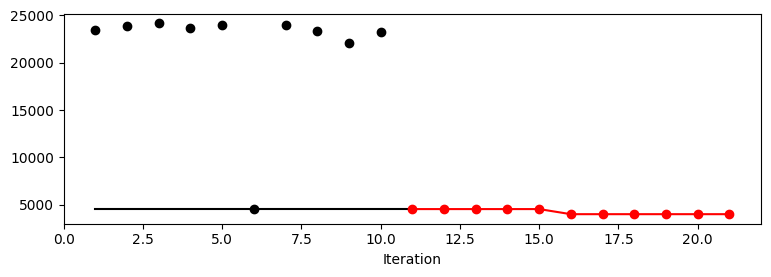

In [5]:
spot_tuner.plot_progress()

### Tuned Hyperparameters and Their Importance

Results can be printed in tabular form.

In [6]:
from spotpython.utils.eda import gen_design_table
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name           | type   | default   |   lower |   upper | tuned               | transform             |   importance | stars   |
|----------------|--------|-----------|---------|---------|---------------------|-----------------------|--------------|---------|
| l1             | int    | 3         |     3.0 |     4.0 | 3.0                 | transform_power_2_int |         0.00 |         |
| epochs         | int    | 4         |     3.0 |     7.0 | 7.0                 | transform_power_2_int |        11.63 | *       |
| batch_size     | int    | 4         |     4.0 |    11.0 | 11.0                | transform_power_2_int |         0.00 |         |
| act_fn         | factor | ReLU      |     0.0 |     5.0 | ReLU                | None                  |         0.00 |         |
| optimizer      | factor | SGD       |     0.0 |     2.0 | Adadelta            | None                  |         0.00 |         |
| dropout_prob   | float  | 0.01      |     0.0 |   0.025 | 0.01565972071452102 | N

A histogram can be used to visualize the most important hyperparameters.

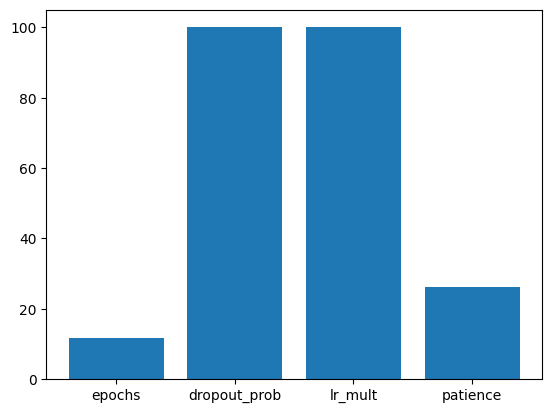

In [7]:
spot_tuner.plot_importance(threshold=1.0)

l1:  0.001
epochs:  11.627910987386626
batch_size:  0.001
act_fn:  0.001
optimizer:  0.001
dropout_prob:  100.0
lr_mult:  100.0
patience:  26.31348984532779
initialization:  0.00842478951799848
impo: [['l1', 0.001], ['epochs', 11.627910987386626], ['batch_size', 0.001], ['act_fn', 0.001], ['optimizer', 0.001], ['dropout_prob', 100.0], ['lr_mult', 100.0], ['patience', 26.31348984532779], ['initialization', 0.00842478951799848]]
indices: [5, 6, 7, 1, 8, 0, 2, 3, 4]
indices after max_imp selection: [5, 6, 7]


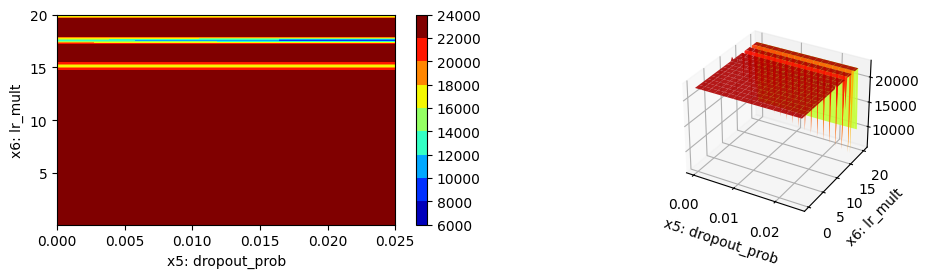

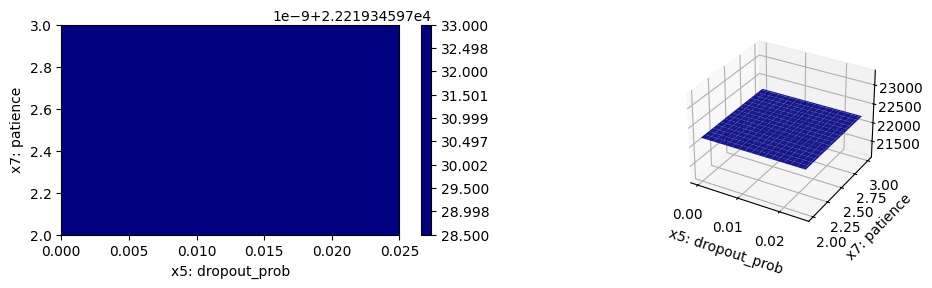

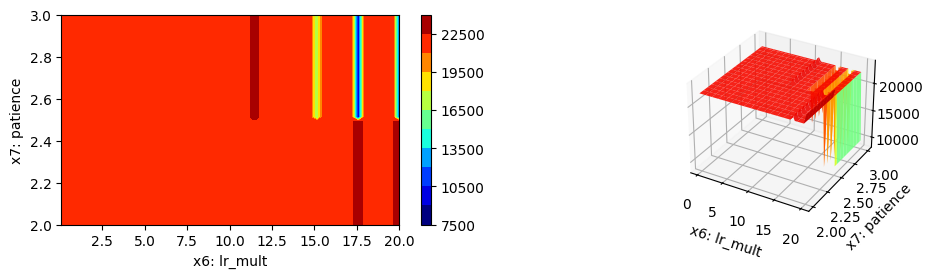

In [8]:
spot_tuner.plot_important_hyperparameter_contour(max_imp=3)

### Get the Tuned Architecture {#sec-get-spot-results-31}

In [9]:
import pprint
from spotpython.hyperparameters.values import get_tuned_architecture
config = get_tuned_architecture(spot_tuner, fun_control)
pprint.pprint(config)

{'act_fn': ReLU(),
 'batch_size': 2048,
 'dropout_prob': 0.01565972071452102,
 'epochs': 128,
 'initialization': 'kaiming_uniform',
 'l1': 8,
 'lr_mult': 17.481358411838603,
 'optimizer': 'Adadelta',
 'patience': 8}


### Test on the full data set

In [10]:
# set the value of the key "TENSORBOARD_CLEAN" to True in the fun_control dictionary and use the update() method to update the fun_control dictionary
import os
# if the directory "./runs" exists, delete it
if os.path.exists("./runs"):
    os.system("rm -r ./runs")
fun_control.update({"tensorboard_log": True})

In [11]:
from spotpython.light.testmodel import test_model
from spotpython.utils.init import get_feature_names

test_model(config, fun_control)
get_feature_names(fun_control)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode
Restoring states from the checkpoint path at /Users/bartz/workspace/Hyperparameter-Tuning-Cookbook/runs/saved_models/8_128_2048_ReLU_Adadelta_0.0157_17.4814_8_kaiming_uniform_TEST/last.ckpt
Loaded model weights from the checkpoint at /Users/bartz/workspace/Hyperparameter-Tuning-Cookbook/runs/saved_models/8_128_2048_ReLU_Adadelta_0.0157_17.4814_8_kaiming_uniform_TEST/last.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      4261.4482421875      │
│         val_loss          │      4261.4482421875      │
└───────────────────────────┴───────────────────────────┘

test_model result: {'val_loss': 4261.4482421875, 'hp_metric': 4261.4482421875}


['age',
 'sex',
 'bmi',
 'bp',
 's1_tc',
 's2_ldl',
 's3_hdl',
 's4_tch',
 's5_ltg',
 's6_glu']

### Cross Validation With Lightning

* The `KFold` class from `sklearn.model_selection` is used to generate the folds for cross-validation.
* These mechanism is used to generate the folds for the final evaluation of the model.
* The `CrossValidationDataModule` class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotpython/blob/main/src/spotpython/data/lightcrossvalidationdatamodule.py) is used to generate the folds for the hyperparameter tuning process.
* It is called from the `cv_model` function [[SOURCE]](https://github.com/sequential-parameter-optimization/spotpython/blob/main/src/spotpython/light/cvmodel.py).

In [12]:
config

{'l1': 8,
 'epochs': 128,
 'batch_size': 2048,
 'act_fn': ReLU(),
 'optimizer': 'Adadelta',
 'dropout_prob': 0.01565972071452102,
 'lr_mult': 17.481358411838603,
 'patience': 8,
 'initialization': 'kaiming_uniform'}

In [13]:
from spotpython.light.cvmodel import cv_model
fun_control.update({"k_folds": 2})
fun_control.update({"test_size": 0.6})
cv_model(config, fun_control)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


k: 0
Train Dataset Size: 221
Val Dataset Size: 221


`Trainer.fit` stopped: `max_epochs=128` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 637    | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
637       Trainable params
0         Non-trainable params
637       Total params
0.003     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 8519.5078125, 'hp_metric': 8519.5078125}
k: 1
Train Dataset Size: 221
Val Dataset Size: 221
train_model result: {'val_loss': 3927.25244140625, 'hp_metric': 3927.25244140625}


6223.380126953125

## Summary

This section presented an introduction to the basic setup of hyperparameter tuning with `spotpython` and `PyTorch` Lightning using a ResNet model for the Diabetes data set.
